In [28]:
import pandas as pd
import numpy as np

In [30]:
a = pd.DataFrame(data = np.random.rand(1000,10),columns = [str(i) for i in range(10)])

In [33]:
a.values

array([[0.25846906, 0.03785747, 0.23234635, ..., 0.68374888, 0.32184159,
        0.09019078],
       [0.81181967, 0.80679867, 0.69644598, ..., 0.38056407, 0.49732019,
        0.5198137 ],
       [0.07951572, 0.74425122, 0.94826937, ..., 0.05761809, 0.1361473 ,
        0.86564994],
       ...,
       [0.28105998, 0.77514205, 0.2807697 , ..., 0.76743545, 0.39204377,
        0.82949678],
       [0.70607607, 0.01539101, 0.0342363 , ..., 0.01204546, 0.81598991,
        0.28592264],
       [0.22851607, 0.36831672, 0.1826595 , ..., 0.36910383, 0.95202619,
        0.36125956]])

In [34]:
import community

In [ ]:
community.best_partition()

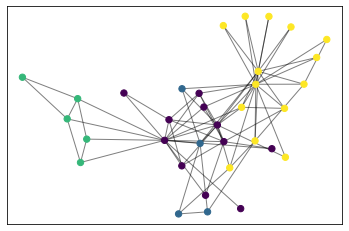

In [35]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
G = nx.karate_club_graph()
# compute the best partition
partition = community_louvain.best_partition(G)

# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, 
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [48]:
from tqdm import tqdm

In [68]:
class EgoNetSplitter(object):

    def __init__(self, edge_df):
        
        self.edge_df = edge_df
    
    def _make_graph(self):
        
        self.graph = nx.from_edgelist([(cust,opp) for cust, opp in zip(self.edge_df['cust_id'],
                                                                 self.edge_df['opp_id'])])
        self.graph.remove_edges_from(nx.selfloop_edges(self.graph))

    def _create_egonet(self, node):
        """
        Creating an ego net, extracting personas and partitioning it.

        Args:
            node: Node ID for egonet (ego node).
        """
        ego_net_minus_ego = self.graph.subgraph(self.graph.neighbors(node))
        components = {i: n for i, n in enumerate(nx.connected_components(ego_net_minus_ego))}
        new_mapping = {}
        personalities = []
        for k, v in components.items():
            personalities.append(self.index)
            for other_node in v:
                new_mapping[other_node] = self.index
            self.index = self.index+1
        self.components[node] = new_mapping
        self.personalities[node] = personalities

    def _create_egonets(self):
        """
        Creating an egonet for each node.
        """
        self.components = {}
        self.personalities = {}
        self.index = 0
        print("Creating egonets.")
        for node in tqdm(self.graph.nodes()):
            self._create_egonet(node)

    def _map_personalities(self):
        """
        Mapping the personas to new nodes.
        """
        self.personality_map = {p: n for n in self.graph.nodes() for p in self.personalities[n]}

    def _get_new_edge_ids(self, edge):
        """
        Getting the new edge identifiers.
        Args:
            edge: Edge being mapped to the new identifiers.
        """
        return (self.components[edge[0]][edge[1]], self.components[edge[1]][edge[0]])

    def _create_persona_graph(self):
        """
        Create a persona graph using the egonet components.
        """
        print("Creating the persona graph.")
        self.persona_graph_edges = [self._get_new_edge_ids(e) for e in tqdm(self.graph.edges())]
        self.persona_graph = nx.from_edgelist(self.persona_graph_edges)

    def _create_partitions(self):
        """
        Creating a non-overlapping clustering of nodes in the persona graph.
        """
        print("Clustering the persona graph.")
        self.partitions = community.best_partition(self.persona_graph, resolution = 1.0)
        self.overlapping_partitions = {node: [] for node in self.graph.nodes()}
        for node, membership in self.partitions.items():
            self.overlapping_partitions[self.personality_map[node]].append(membership)

    def fit(self):
        """
        Fitting an Ego-Splitter clustering model.

        """
        self._make_graph()
        self._create_egonets()
        self._map_personalities()
        self._create_persona_graph()
        self._create_partitions()

    def get_memberships(self):
        r"""Getting the cluster membership of nodes.
        Return types:
            * **memberships** *(dictionary of lists)* - Cluster memberships.
        """
        return self.overlapping_partitions


In [69]:
import sys
sys.path.append('..')
from graphSAGE_v0.random_graph import random_graph_gcn

In [70]:
_,edge_df = random_graph_gcn(1000,4000)

In [74]:
import egoSplitting

In [75]:
a = egoSplitting.EgoNetSplitter(edge_df)

In [76]:
a.fit()

Creating egonets.


100%|██████████| 1000/1000 [00:00<00:00, 6431.16it/s]


Creating the persona graph.


100%|██████████| 3978/3978 [00:00<00:00, 469654.37it/s]

Clustering the persona graph.


In [77]:
a.get_memberships()

{0: [0, 4, 5, 8, 10, 11, 14, 16],
 72: [0, 18, 19, 22, 23, 26, 30],
 374: [4, 32, 35, 37, 38, 41],
 716: [4, 43, 45, 47, 48, 50, 53, 55, 57],
 261: [5, 59, 60, 63, 65, 66, 69, 71, 73, 74, 77],
 735: [8, 79, 81, 83, 85, 88, 91, 92],
 873: [10, 95, 96, 98, 101, 102, 104, 106],
 599: [11, 109, 110, 113, 114, 116, 118],
 533: [14, 120, 123, 125],
 592: [16, 127, 128, 131, 133, 136, 139],
 1: [140, 142, 144],
 172: [140, 146, 149, 150, 152, 154],
 147: [142, 157, 159, 161, 162, 165, 166, 169, 171, 172, 174, 176, 178],
 15: [144, 181, 183, 185, 186, 189, 191],
 2: [192, 195, 197, 198, 200, 203, 205, 207, 208, 210, 212],
 745: [192, 215, 217, 219, 220, 222, 224, 227, 229],
 959: [195, 230, 232, 234, 236, 238, 240],
 587: [197, 242, 245, 247, 248, 250, 252],
 399: [198, 254, 257, 258, 260, 263, 264, 266, 269, 270, 273],
 528: [200, 274, 277, 279, 280, 283, 285],
 403: [95, 203, 287, 288, 290, 293, 294, 297, 298, 300, 303],
 796: [205, 304, 306, 308, 311, 313, 315, 316, 319, 320, 322, 324],
 70

In [78]:
community.__version__

'0.15'

In [79]:
nx.__version__

'2.5.1'